In [1]:
#!pip install music21

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import music21 as m21

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

1 = G

2 = D

3 = A

4 = E

# Project presentation

The project aims to develop a model capable to humanise a specific form of music notation, i. e. tablature (tab). Most of western music is written in staff notation, but for some specific instruments like guitar or bass in popular music, tablatures are also very common, especially for people with little to no music theory knowledge, as it allows to read music through the position on the instrument and not the notes themselves.

Modern music notation softwares are capable to convert music sheets from staff to tab notation, but the conversion doesn't take into account the practicality of the positions on the instruments, leading to music parts that are technically impossible to play. The musician who wants to convert a staff notated music sheet into tablature must therefore edit the position of each note by hand, and it's a long and tedious work.

The aim of this project is to train a ML model on humanly playable tablatures, in order to be able to make a conversion from staff notation to tab that it's actually playable by a human.

<div>
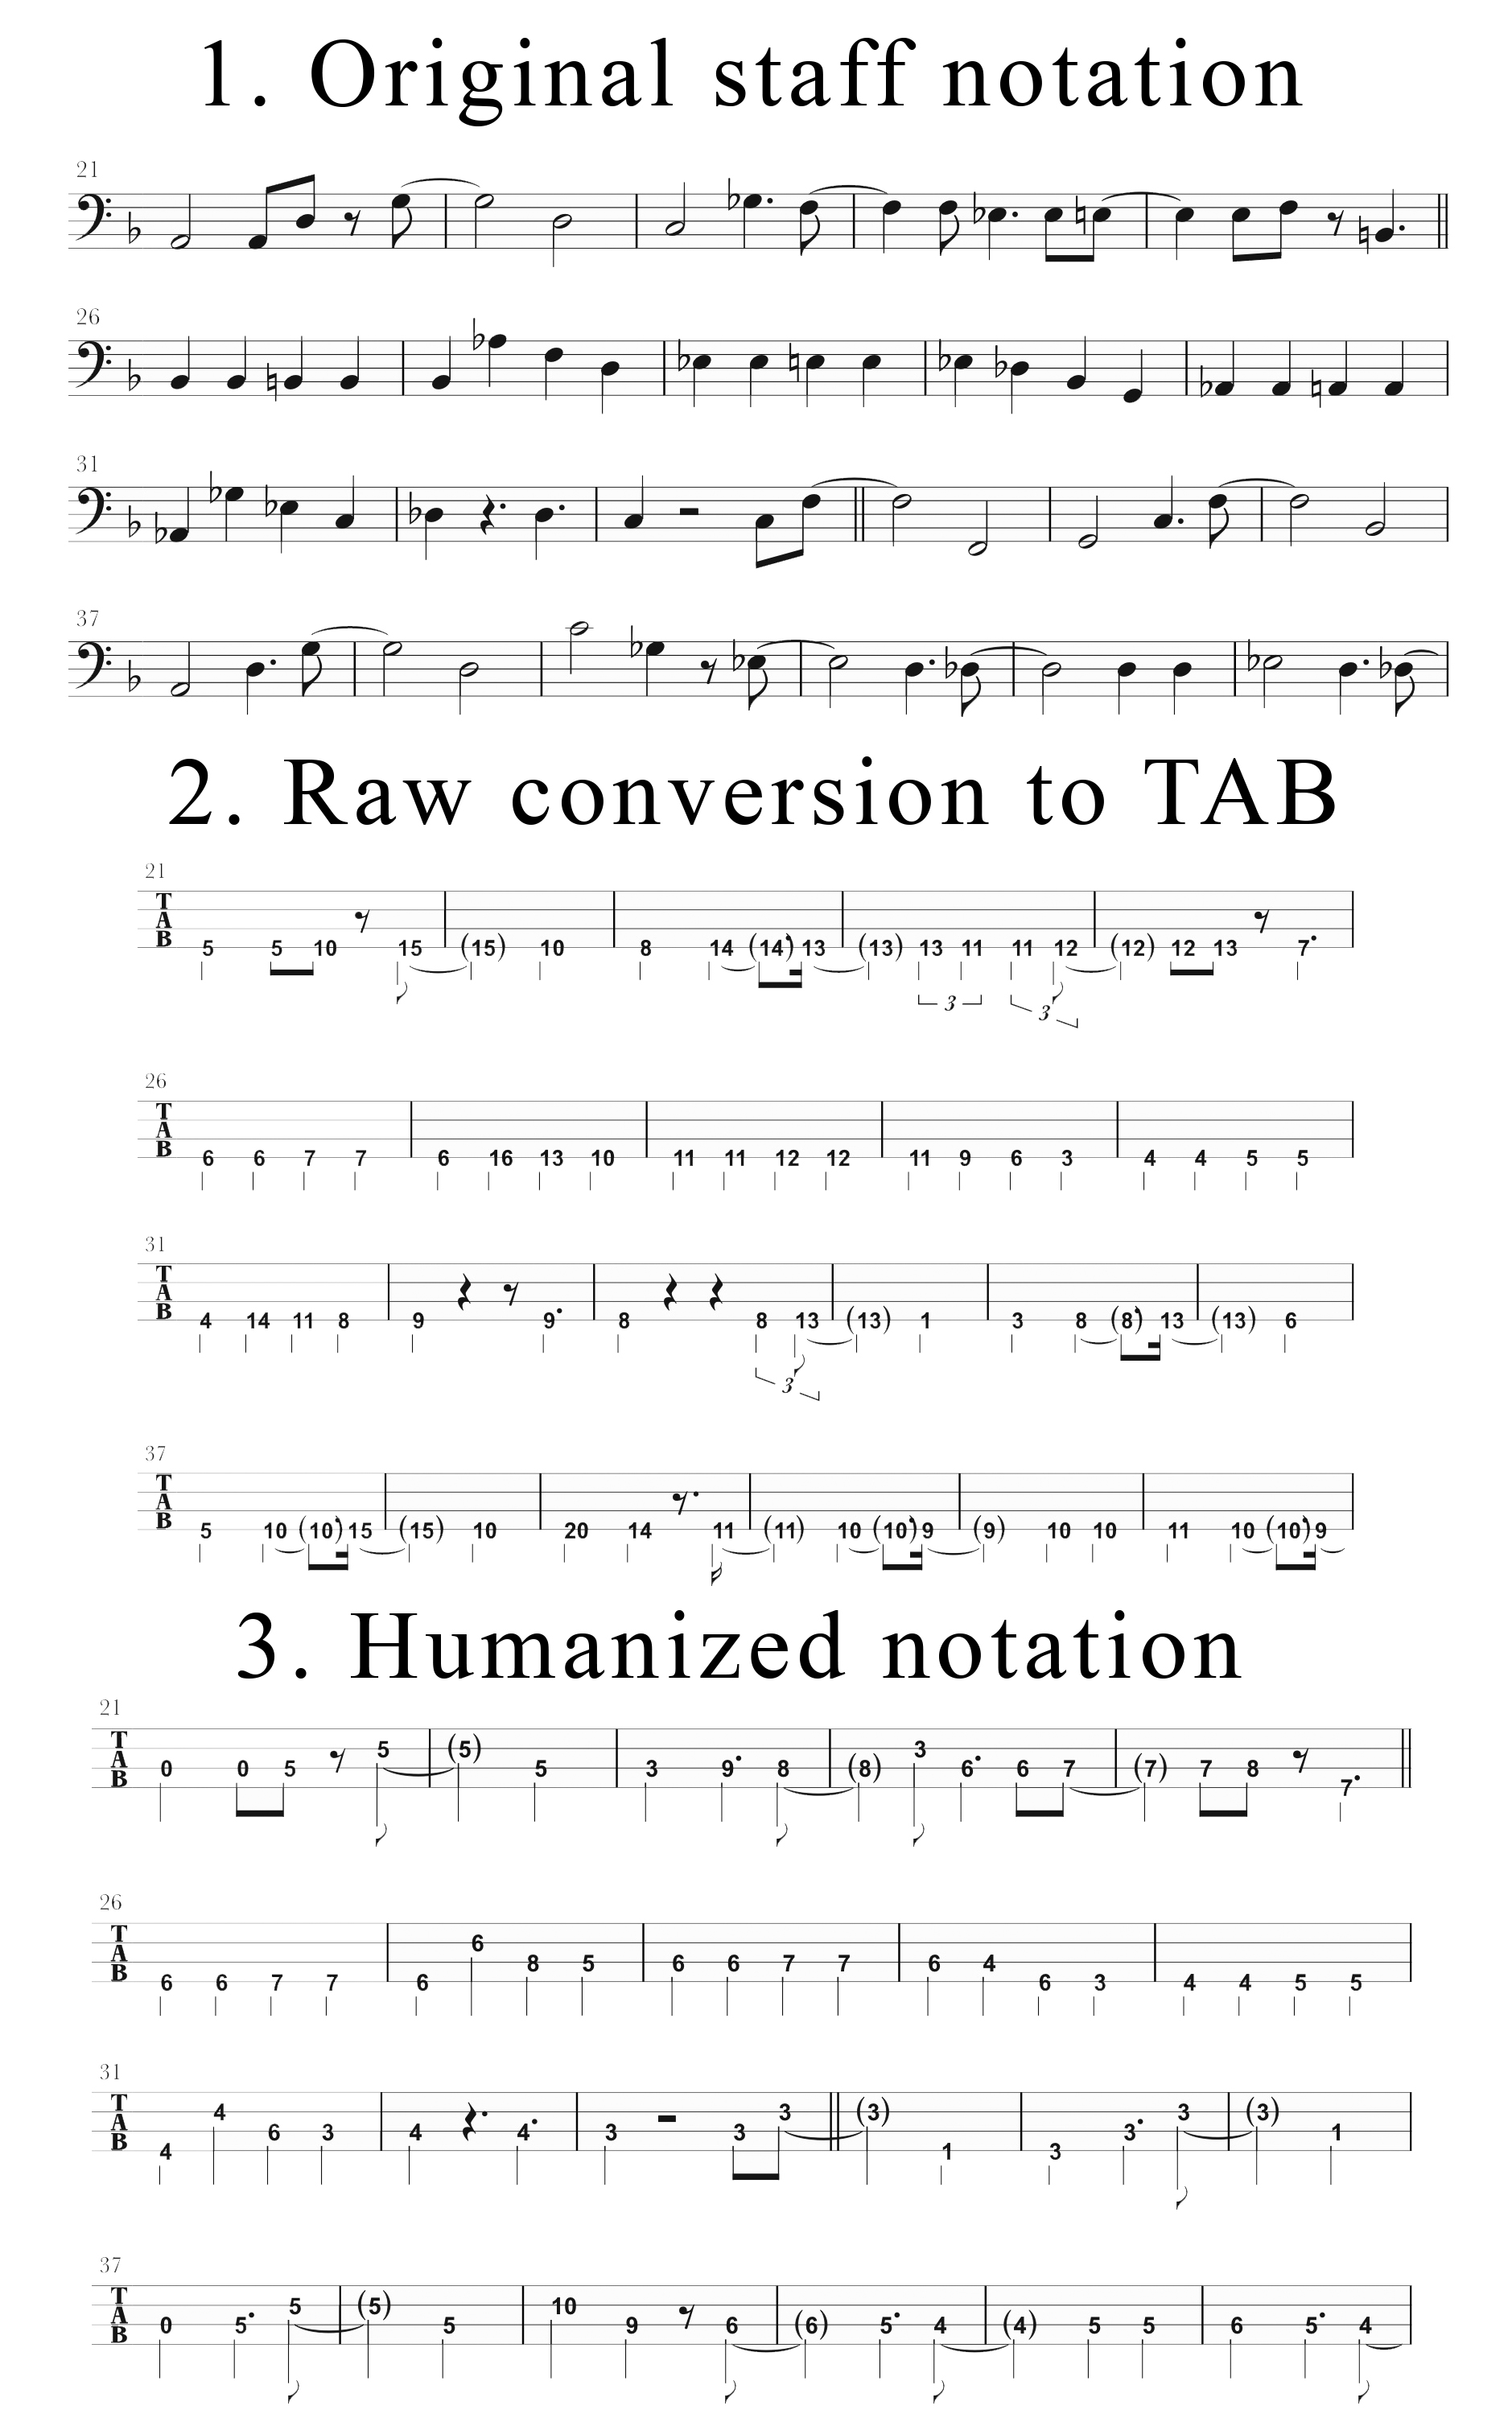
</div>

Two main formats are used nowadays to deal with music notation digitally: <b>MIDI</b> and <b>MusicXML</b>, but only the latter is capable of storing the information of the string and fret (i. e. the position on the instrument) of the note played. Here's an example taken from the bass part of the jazz standard "Stompin' at the Savoy".

In [3]:
fn = "xml/Sweet.musicxml"

with open(fn, 'r') as stream:
    xml_str = stream.read()

start = xml_str.find('<note')
end = xml_str[start:].find('</note>') + start + len('</note>')
print(xml_str[start:end])

<note>
				<rest/>
				<duration>16</duration>
				<voice>1</voice>
				<type>whole</type>
				<staff>1</staff>
			</note>


The first note of the music sheet is a rest of duration 16 thirty-second notes, which is equal to a half note.

In [4]:
def xml_to_list(xml):
    """Convert a music xml file to a list of note events

    Notebook: C1/C1S2_MusicXML.ipynb

    Args:
        xml (str or music21.stream.Score): Either a path to a music xml file or a music21.stream.Score

    Returns:
        score (list): A list of note events where each note is specified as
            ``[start, duration, pitch, velocity, label]``
    """

    if isinstance(xml, str):
        xml_data = m21.converter.parse(xml)
    elif isinstance(xml, m21.stream.Score):
        xml_data = xml
    else:
        raise RuntimeError('midi must be a path to a midi file or music21.stream.Score')

    score = []

    for part in xml_data.parts:
        for note in part.flat.notes:
            measure = note.measureNumber
            pitch = note.pitch.ps
            string = str(note.articulations[0])[-2:-1]
            fret = str(note.articulations[1])[-3:-1]
            score.append([string, fret])
    return score

xml_data = m21.converter.parse(fn)
xml_list = xml_to_list(xml_data)

df_raw = pd.DataFrame(xml_list, columns=['string', 'fret'])
df_raw

,string,fret
0,3,8
1,4,6
2,4,7
3,4,8
4,4,8
...,...,...
417,3,5
418,3,3
419,4,5
420,4,1


# Loading data

In [5]:
def add_tablature(fn, df_raw):
    xml_data = m21.converter.parse(fn)
    xml_list = xml_to_list(xml_data)

    df_temp = pd.DataFrame(xml_list, columns=['string', 'fret'])
    return pd.concat([df_raw, df_temp], ignore_index=True)

In [6]:
df_raw = add_tablature("xml/Alexander.musicxml", df_raw)
df_raw = add_tablature("xml/Amazing.musicxml", df_raw)
df_raw = add_tablature("xml/At last.musicxml", df_raw)
df_raw = add_tablature("xml/Basie.musicxml", df_raw)
df_raw = add_tablature("xml/Besame.musicxml", df_raw)
df_raw = add_tablature("xml/Blue.musicxml", df_raw)
df_raw = add_tablature("xml/Cantaloupe.musicxml", df_raw)
df_raw = add_tablature("xml/Copains.musicxml", df_raw)
df_raw = add_tablature("xml/Creep.musicxml", df_raw)
df_raw = add_tablature("xml/Easy.musicxml", df_raw)
df_raw = add_tablature("xml/Everybody.musicxml", df_raw)
df_raw = add_tablature("xml/Feeling.musicxml", df_raw)
df_raw = add_tablature("xml/Final.musicxml", df_raw)
df_raw = add_tablature("xml/Gonna.musicxml", df_raw)
df_raw = add_tablature("xml/Hallelujah.musicxml", df_raw)
df_raw = add_tablature("xml/If.musicxml", df_raw)
df_raw = add_tablature("xml/It dont.musicxml", df_raw)
df_raw = add_tablature("xml/Its oh.musicxml", df_raw)
df_raw = add_tablature("xml/Ipanema.musicxml", df_raw)
df_raw = add_tablature("xml/Jingle.musicxml", df_raw)
df_raw = add_tablature("xml/Louis.musicxml", df_raw)
df_raw = add_tablature("xml/Mack.musicxml", df_raw)
df_raw = add_tablature("xml/Mancini.musicxml", df_raw)
df_raw = add_tablature("xml/Manha.musicxml", df_raw)
df_raw = add_tablature("xml/One.musicxml", df_raw)
df_raw = add_tablature("xml/Over.musicxml", df_raw)
df_raw = add_tablature("xml/Proud.musicxml", df_raw)
df_raw = add_tablature("xml/Respect.musicxml", df_raw)
df_raw = add_tablature("xml/Seven.musicxml", df_raw)
df_raw = add_tablature("xml/Should.musicxml", df_raw)
df_raw = add_tablature("xml/Smoke.musicxml", df_raw)
df_raw = add_tablature("xml/Son.musicxml", df_raw)
df_raw = add_tablature("xml/Summertime.musicxml", df_raw)
df_raw = add_tablature("xml/Take.musicxml", df_raw)
df_raw = add_tablature("xml/Tequila.musicxml", df_raw)
df_raw = add_tablature("xml/What.musicxml", df_raw)
df_raw = add_tablature("xml/When.musicxml", df_raw)
df_raw = add_tablature("xml/Wonderful.musicxml", df_raw)
df_raw = add_tablature("xml/Y.M.C.A.musicxml", df_raw)








df_raw = add_tablature("xml/Thriller.musicxml", df_raw)
df_raw = add_tablature("xml/White.musicxml", df_raw)
df_raw = add_tablature("xml/Cjam.musicxml", df_raw)
#df_raw = add_tablature("xml/.musicxml", df_raw)

df_raw

,string,fret
0,3,8
1,4,6
2,4,7
3,4,8
4,4,8
...,...,...
14304,2,5
14305,2,7
14306,2,8
14307,4,6


# Generate dataset with contextual information

In [7]:
def generate_contextual_dataframe(df):
    
    data = list()
    
    for i in range(len(df_raw)-1):
        if i == 0 :
            data.append([df_raw.iloc[i, 0], df_raw.iloc[i, 1], df_raw.iloc[i, 0], df_raw.iloc[i, 1], df_raw.iloc[i, 0], df_raw.iloc[i, 1], df_raw.iloc[i+1, 0], df_raw.iloc[i+1, 1], df_raw.iloc[i+2, 0], df_raw.iloc[i+2, 1]])
        if i == 1 :
            data.append([df_raw.iloc[i-1, 0], df_raw.iloc[i-1, 1], df_raw.iloc[i-1, 0], df_raw.iloc[i-1, 1], df_raw.iloc[i, 0], df_raw.iloc[i, 1], df_raw.iloc[i+1, 0], df_raw.iloc[i+1, 1], df_raw.iloc[i+2, 0], df_raw.iloc[i+2, 1]])
        if i == len(df_raw)-2 :
            data.append([df_raw.iloc[i-2, 0], df_raw.iloc[i-2, 1], df_raw.iloc[i-1, 0], df_raw.iloc[i-1, 1], df_raw.iloc[i, 0], df_raw.iloc[i, 1], df_raw.iloc[i+1, 0], df_raw.iloc[i+1, 1], df_raw.iloc[i+1, 0], df_raw.iloc[i+1, 1]])
        else : 
            data.append([df_raw.iloc[i-2, 0], df_raw.iloc[i-2, 1], df_raw.iloc[i-1, 0], df_raw.iloc[i-1, 1], df_raw.iloc[i, 0], df_raw.iloc[i, 1], df_raw.iloc[i+1, 0], df_raw.iloc[i+1, 1], df_raw.iloc[i+2, 0], df_raw.iloc[i+2, 1]])
#    data.append([df_raw.iloc[i, 0], df_raw.iloc[i, 1], df_raw.iloc[i, 0], df_raw.iloc[i, 1], df_raw.iloc[i+1, 0], df_raw.iloc[i+1, 1]])
    
    df = pd.DataFrame(data = data, columns=['s-2', 'f-2', 's-1', 'f-1', 's0', 'f0', 's+1', 'f+1', 's+2', 'f+2'])
    df['y'] = df.s0
    
    for column in df.columns:
        df[column] = pd.to_numeric(df[column], errors='coerce').astype(int)
    return df

In [8]:
df = generate_contextual_dataframe(df_raw)

df

,s-2,f-2,s-1,f-1,s0,f0,s+1,f+1,s+2,f+2,y
0,3,8,3,8,3,8,4,6,4,7,3
1,4,6,4,6,3,8,4,6,4,7,3
2,3,8,3,8,4,6,4,7,4,8,4
3,4,6,3,8,4,6,4,7,4,8,4
4,3,8,4,6,4,7,4,8,4,8,4
...,...,...,...,...,...,...,...,...,...,...,...
14305,3,6,3,7,3,8,2,5,2,7,3
14306,3,7,3,8,2,5,2,7,2,8,2
14307,3,8,2,5,2,7,2,8,4,6,2
14308,2,5,2,7,2,8,4,6,4,6,2


In [9]:
def augment_data_up(row):
    if row[5] + 5 <= 15 and row[4] < 4 :
        row[4] += 1
        row[5] += 5
    return row

augmented_data = list()

for i in range(len(df)):
    augmented_data.append(augment_data_up(list(df.loc[i])))

df_up = pd.DataFrame(data = augmented_data, columns=['s-2', 'f-2', 's-1', 'f-1', 's0', 'f0', 's+1', 'f+1', 's+2', 'f+2', 'y'])
df_up

,s-2,f-2,s-1,f-1,s0,f0,s+1,f+1,s+2,f+2,y
0,3,8,3,8,4,13,4,6,4,7,3
1,4,6,4,6,4,13,4,6,4,7,3
2,3,8,3,8,4,6,4,7,4,8,4
3,4,6,3,8,4,6,4,7,4,8,4
4,3,8,4,6,4,7,4,8,4,8,4
...,...,...,...,...,...,...,...,...,...,...,...
14305,3,6,3,7,4,13,2,5,2,7,3
14306,3,7,3,8,3,10,2,7,2,8,2
14307,3,8,2,5,3,12,2,8,4,6,2
14308,2,5,2,7,3,13,4,6,4,6,2


In [10]:
def augment_data_all_up(row):
    for i in range(1,11,2):
        if row[i] + 5 <= 15 and row[i-1] < 4 :
            row[i-1] += 1
            row[i] += 5
    return row

augmented_data = list()

for i in range(len(df)):
    augmented_data.append(augment_data_all_up(list(df.loc[i])))

df_all_up = pd.DataFrame(data = augmented_data, columns=['s-2', 'f-2', 's-1', 'f-1', 's0', 'f0', 's+1', 'f+1', 's+2', 'f+2', 'y'])
df_all_up

,s-2,f-2,s-1,f-1,s0,f0,s+1,f+1,s+2,f+2,y
0,4,13,4,13,4,13,4,6,4,7,3
1,4,6,4,6,4,13,4,6,4,7,3
2,4,13,4,13,4,6,4,7,4,8,4
3,4,6,4,13,4,6,4,7,4,8,4
4,4,13,4,6,4,7,4,8,4,8,4
...,...,...,...,...,...,...,...,...,...,...,...
14305,4,11,4,12,4,13,3,10,3,12,3
14306,4,12,4,13,3,10,3,12,3,13,2
14307,4,13,3,10,3,12,3,13,4,6,2
14308,3,10,3,12,3,13,4,6,4,6,2


In [11]:
def augment_data_down(row):
    if row[5] - 5 >= 0 and row[4] > 1:
        row[4] -= 1
        row[5] -= 5
    return row

augmented_data = list()

for i in range(len(df)):
    augmented_data.append(augment_data_down(list(df.loc[i])))

df_down = pd.DataFrame(data = augmented_data, columns=['s-2', 'f-2', 's-1', 'f-1', 's0', 'f0', 's+1', 'f+1', 's+2', 'f+2', 'y'])
df_down

,s-2,f-2,s-1,f-1,s0,f0,s+1,f+1,s+2,f+2,y
0,3,8,3,8,2,3,4,6,4,7,3
1,4,6,4,6,2,3,4,6,4,7,3
2,3,8,3,8,3,1,4,7,4,8,4
3,4,6,3,8,3,1,4,7,4,8,4
4,3,8,4,6,3,2,4,8,4,8,4
...,...,...,...,...,...,...,...,...,...,...,...
14305,3,6,3,7,2,3,2,5,2,7,3
14306,3,7,3,8,1,0,2,7,2,8,2
14307,3,8,2,5,1,2,2,8,4,6,2
14308,2,5,2,7,1,3,4,6,4,6,2


In [12]:
def augment_data_all_down(row):
    for i in range(1,11,2):
        if row[i] - 5 >= 0 and row[i-1] > 1:
            row[i-1] -= 1
            row[i] -= 5
    return row

augmented_data = list()

for i in range(len(df)):
    augmented_data.append(augment_data_all_down(list(df.loc[i])))

df_all_down = pd.DataFrame(data = augmented_data, columns=['s-2', 'f-2', 's-1', 'f-1', 's0', 'f0', 's+1', 'f+1', 's+2', 'f+2', 'y'])
df_all_down

,s-2,f-2,s-1,f-1,s0,f0,s+1,f+1,s+2,f+2,y
0,2,3,2,3,2,3,3,1,3,2,3
1,3,1,3,1,2,3,3,1,3,2,3
2,2,3,2,3,3,1,3,2,3,3,4
3,3,1,2,3,3,1,3,2,3,3,4
4,2,3,3,1,3,2,3,3,3,3,4
...,...,...,...,...,...,...,...,...,...,...,...
14305,2,1,2,2,2,3,1,0,1,2,3
14306,2,2,2,3,1,0,1,2,1,3,2
14307,2,3,1,0,1,2,1,3,3,1,2
14308,1,0,1,2,1,3,3,1,3,1,2


In [13]:
merged_data = []
for i in range(len(df)):
   merged_data.append(list(df.iloc[i]))
   merged_data.append(list(df_up.iloc[i]))
   merged_data.append(list(df_all_up.iloc[i]))
   merged_data.append(list(df_down.iloc[i]))
   merged_data.append(list(df_all_down.iloc[i]))
merged_df = pd.DataFrame(data = merged_data, columns = ['s-2', 'f-2', 's-1', 'f-1', 's0', 'f0', 's+1', 'f+1', 's+2', 'f+2', 'y'])
merged_df

,s-2,f-2,s-1,f-1,s0,f0,s+1,f+1,s+2,f+2,y
0,3,8,3,8,3,8,4,6,4,7,3
1,3,8,3,8,4,13,4,6,4,7,3
2,4,13,4,13,4,13,4,6,4,7,3
3,3,8,3,8,2,3,4,6,4,7,3
4,2,3,2,3,2,3,3,1,3,2,3
...,...,...,...,...,...,...,...,...,...,...,...
71545,2,7,2,8,4,6,4,6,4,6,4
71546,2,7,2,8,4,6,4,6,4,6,4
71547,3,12,3,13,4,6,4,6,4,6,4
71548,2,7,2,8,3,1,4,6,4,6,4


In [14]:
df = merged_df.sample(frac=1)

X = df.iloc[:, :10]
y = df.iloc[:, 10]

Here we extracted the data of only musical notes - not rests, with their measure, the pitch of the note, the string of the instrument and the fret.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
catboost_model = CatBoostClassifier()

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [6, 8, 10],
    'n_estimators': [50, 100, 200],
    'l2_leaf_reg': [1, 3, 5],
    'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],
}

grid_search = GridSearchCV(catboost_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, error_score='raise')

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

model = grid_search.best_estimator_

0:	learn: 1.2028866	total: 193ms	remaining: 38.4s
1:	learn: 1.0655523	total: 237ms	remaining: 23.4s
2:	learn: 0.9647666	total: 282ms	remaining: 18.5s
3:	learn: 0.8805352	total: 329ms	remaining: 16.1s
4:	learn: 0.8121212	total: 377ms	remaining: 14.7s
5:	learn: 0.7530878	total: 420ms	remaining: 13.6s
6:	learn: 0.7041703	total: 462ms	remaining: 12.7s
7:	learn: 0.6619911	total: 503ms	remaining: 12.1s
8:	learn: 0.6255322	total: 544ms	remaining: 11.6s
9:	learn: 0.5937332	total: 594ms	remaining: 11.3s
10:	learn: 0.5650664	total: 637ms	remaining: 10.9s
11:	learn: 0.5395989	total: 681ms	remaining: 10.7s
12:	learn: 0.5173690	total: 722ms	remaining: 10.4s
13:	learn: 0.4969439	total: 761ms	remaining: 10.1s
14:	learn: 0.4802237	total: 800ms	remaining: 9.87s
15:	learn: 0.4637082	total: 838ms	remaining: 9.64s
16:	learn: 0.4492408	total: 878ms	remaining: 9.45s
17:	learn: 0.4363618	total: 917ms	remaining: 9.27s
18:	learn: 0.4243201	total: 956ms	remaining: 9.11s
19:	learn: 0.4149930	total: 996ms	remaini

In [30]:
print(grid_search.best_params_)

{'bootstrap_type': 'Bayesian', 'depth': 10, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'n_estimators': 200}


In [21]:
predictions = model.predict(X_test)

0:	learn: 1.2028866	total: 34.4ms	remaining: 6.84s
1:	learn: 1.0655523	total: 62.9ms	remaining: 6.22s
2:	learn: 0.9647666	total: 90.2ms	remaining: 5.92s
3:	learn: 0.8805352	total: 118ms	remaining: 5.77s
4:	learn: 0.8121212	total: 145ms	remaining: 5.65s
5:	learn: 0.7530878	total: 172ms	remaining: 5.57s
6:	learn: 0.7041703	total: 201ms	remaining: 5.55s
7:	learn: 0.6619911	total: 230ms	remaining: 5.51s
8:	learn: 0.6255322	total: 260ms	remaining: 5.51s
9:	learn: 0.5937332	total: 287ms	remaining: 5.46s
10:	learn: 0.5650664	total: 317ms	remaining: 5.45s
11:	learn: 0.5395989	total: 345ms	remaining: 5.4s
12:	learn: 0.5173690	total: 371ms	remaining: 5.34s
13:	learn: 0.4969439	total: 398ms	remaining: 5.29s
14:	learn: 0.4802237	total: 424ms	remaining: 5.23s
15:	learn: 0.4637082	total: 450ms	remaining: 5.18s
16:	learn: 0.4492408	total: 479ms	remaining: 5.16s
17:	learn: 0.4363618	total: 506ms	remaining: 5.12s
18:	learn: 0.4243201	total: 532ms	remaining: 5.06s
19:	learn: 0.4149930	total: 572ms	remai

In [22]:
predictions, y_test

(array([[4],
        [2],
        [2],
        ...,
        [4],
        [3],
        [3]], dtype=int64),
 45569    4
 6239     2
 12016    2
 15243    3
 22183    2
         ..
 24132    3
 35334    3
 18123    4
 29722    3
 64296    3
 Name: y, Length: 14310, dtype: int64)

In [23]:
X_test

,s-2,f-2,s-1,f-1,s0,f0,s+1,f+1,s+2,f+2
45569,3,3,4,3,3,0,4,3,3,3
6239,1,7,1,5,1,5,1,12,1,5
12016,4,3,3,3,3,10,2,3,4,1
15243,4,6,4,6,2,0,3,8,3,8
22183,2,3,2,4,2,4,2,5,2,7
...,...,...,...,...,...,...,...,...,...,...
24132,3,15,2,12,4,15,4,8,4,10
35334,3,3,3,3,3,1,4,1,3,1
18123,3,7,2,7,3,0,4,5,3,7
29722,3,15,3,15,4,13,4,13,3,15


In [24]:
model.predict(np.array([[2,8,2,8,1,6,2,6,2,6]]))

array([[2]], dtype=int64)

# Model evaluation

### Accuracy

In [25]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: ", accuracy)

Accuracy:  0.9192173305380853


### Precision, recall and F1 score

In [26]:
precision_list = []
recall_list = []
f1_list = []

for i in range(1,5):
    precision_i = precision_score(y_test, predictions, labels=[i], average='micro')
    recall_i = recall_score(y_test, predictions, labels=[i], average='micro')
    f1_i = f1_score(y_test, predictions, labels=[i], average='micro')
    
    precision_list.append(precision_i)
    recall_list.append(recall_i)
    f1_list.append(f1_i)

# Create a DataFrame to display the results
metrics_df = pd.DataFrame({
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
}, index=range(1,5))

# Print the DataFrame
print(metrics_df)


   Precision    Recall  F1 Score
1   0.889126  0.866944  0.877895
2   0.909798  0.922584  0.916146
3   0.917009  0.924444  0.920711
4   0.942606  0.921030  0.931693


### Confusion matrix

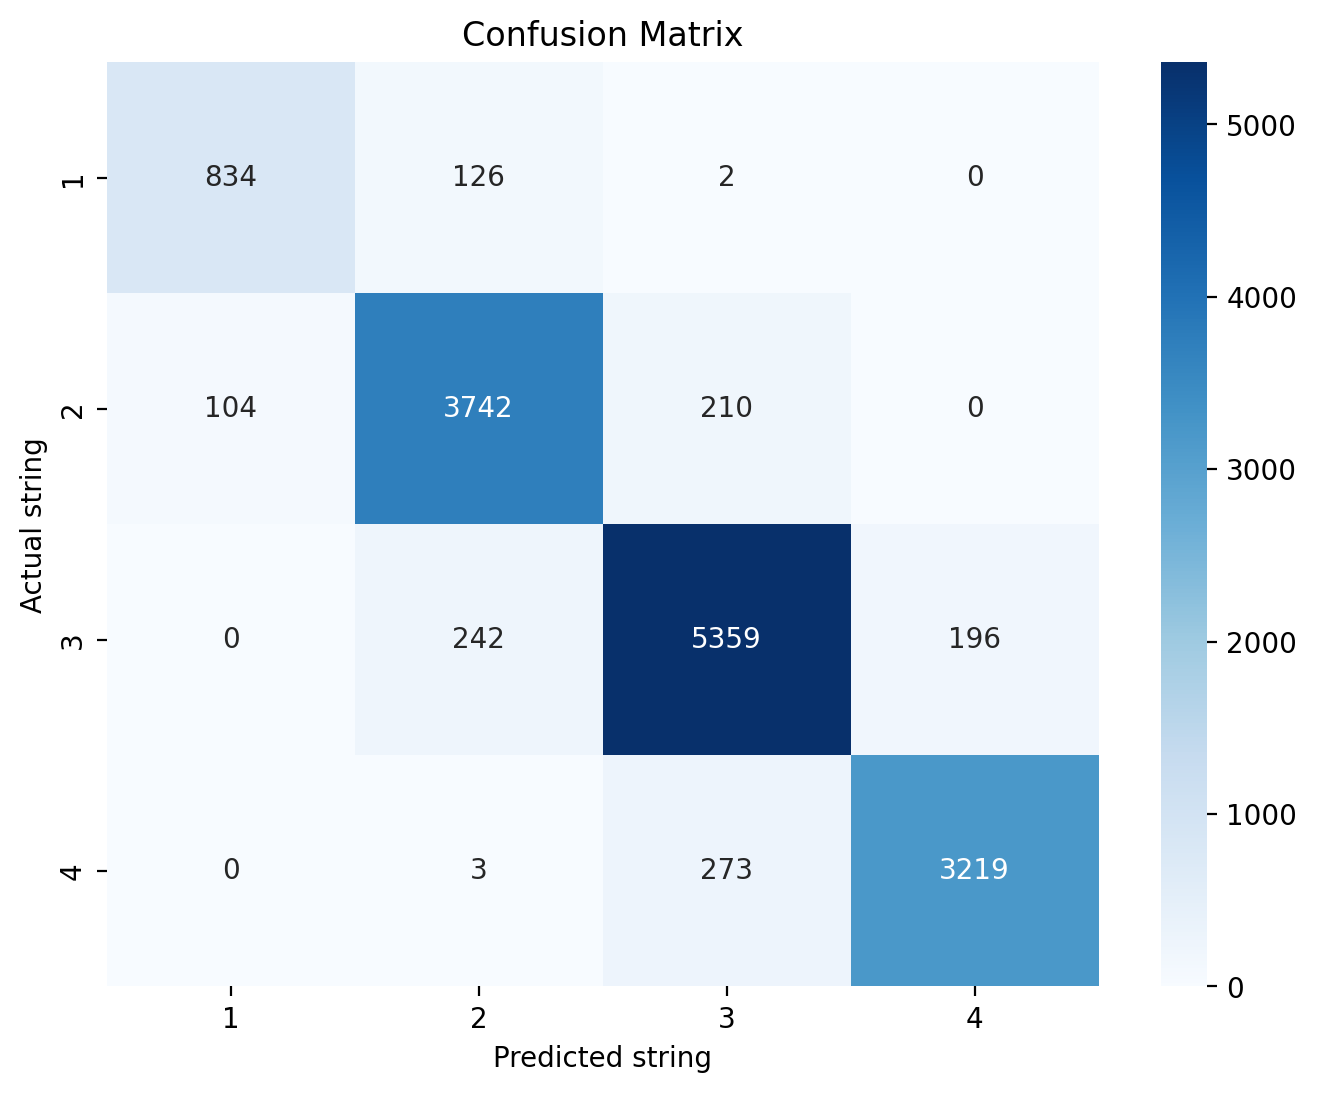

In [27]:
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4], yticklabels=[1, 2, 3, 4])
plt.title('Confusion Matrix')
plt.xlabel('Predicted string')
plt.ylabel('Actual string')
plt.show()

In [28]:
print("Confusion Matrix:")
for i in range(4):
    row_str = " | ".join([f"{conf_matrix[i, j]:2d}" for j in range(4)])
    print(row_str)
    if i < 4 - 1:
        print("-" * (4 * 4 - 1))


Confusion Matrix:
834 | 126 |  2 |  0
---------------
104 | 3742 | 210 |  0
---------------
 0 | 242 | 5359 | 196
---------------
 0 |  3 | 273 | 3219


# Test on external data

In [29]:
fn = "xml/copacabana_basso_tab.mxl"

xml_data = m21.converter.parse(fn)
xml_list = xml_to_list(xml_data)

df_test_raw = pd.DataFrame(xml_list, columns=['string', 'fret'])
df_test_raw

df_test = generate_contextual_dataframe(df_raw)

df_test.drop(columns=['y'], inplace=True)

df_test = df_test.sample(frac=1)

df_test

,s-2,f-2,s-1,f-1,s0,f0,s+1,f+1,s+2,f+2
3389,4,9,4,9,4,8,4,1,4,1
11962,2,10,2,10,3,10,2,10,2,7
12512,1,9,1,12,1,9,1,10,1,10
3665,4,6,3,6,3,6,4,6,4,6
2917,3,8,3,10,3,11,4,11,3,11
...,...,...,...,...,...,...,...,...,...,...
5854,2,5,2,8,3,6,3,4,3,5
12111,2,8,2,8,3,5,3,6,3,8
13932,1,3,3,3,1,5,2,5,3,6
4256,4,4,4,3,4,3,4,3,4,2


In [ ]:
def rescale_tab(row):
    for i in range(1,7,2):
        while row[i] > 12
        if row[i] - 5 >= 0 and row[i-1] > 1:
            row[i-1] -= 1
            row[i] -= 5
    return row

augmented_data = list()

for i in range(len(df_test)):
    augmented_data.append(rescale_tab(list(df_test.loc[i])))

df_test = pd.DataFrame(data = augmented_data, columns=['s-1', 'f-1', 's0', 'f0', 's+1', 'f+1', 'y'])
df_test

In [ ]:
for i in range(len(df)):
    print(np.round(model.predict(df.iloc[i])), df.iloc[i]['s0'])

In [ ]:
df['s0'] = [np.round(model.predict(df.iloc[i])) for i in range(len(df))]
df['s0'] = [np.round(model.predict(df.iloc[i])) for i in range(len(df))]
df['s0'] = [np.round(model.predict(df.iloc[i])) for i in range(len(df))]
df['s0'] = [np.round(model.predict(df.iloc[i])) for i in range(len(df))]
df['s0'] = [np.round(model.predict(df.iloc[i])) for i in range(len(df))]

In [ ]:
df

## Regenerate fret data

## Limits

1. Difficult to learn from a note-by-note approach: the model should have some sort of contextual awareness, i. e. for each note it should understand if the string and fret proposed is close to the previous and following one. 

    <b>Possible solution</b>: for each note (row of the dataframe) include previous and following string and fret.
    
    
2. Small amount of data: I currently hold 50 XML files with humanized notation that I personally transcribed during the years. Since this project is just a proof of concept, we can accept a small dataset, and consequently less than optimal results.

3. Little to none academic literature on the topic itself - to my knowledge, it's a problem known in the music field but it has never been tackled. I'm confident that if I broaden the spectrum of the project a bit I will be able to find some literature.